In [1]:
from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/PTI'

Mounted at /content/drive


# **WORKSPACE SET-UP**

In [2]:
!pip install geopandas rioxarray richdem geemap rasterio import_ipynb pyshp pycrs pyogrio rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844529 sha256=b0a2b903d7c583e1e4f44358a6604ddb8a516386ec72d9495afbd1af35b487ba
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116b5cffecf04ed75c40f640e2baf231dae20954e31e0
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32688 sha256=e76320ea4260a978c625af1f320634524a38a74abdc6b90ee06a7fe2538ae60a
  Stored in

In [3]:
# Built-in:
# dir(), print(), range(), format(), int(), len(), list(), max(), min(), zip(), sorted(), sum(), open(), del, = None, try except, with as, for in, if elif else
# Also: list.append(), list.insert(), list.remove(), count(), startswith(), endswith(), contains(), replace()

import os, sys, glob, re, time, subprocess, string # os.getcwd(), os.path.join(), os.listdir(), os.remove(), time.ctime(), glob.glob(), string.zfill(), string.join()
from os.path import exists # exists()
from functools import reduce # reduce()

import geopandas as gpd # read_file(), GeoDataFrame(), sjoin_nearest(), to_crs(), to_file(), .crs, buffer(), dissolve()
import pandas as pd # .dtypes, Series(), concat(), DataFrame(), read_table(), merge(), to_csv(), .loc[], head(), sample(), astype(), unique(), rename(), between(), drop(), fillna(), idxmax(), isna(), isin(), apply(), info(), sort_values(), notna(), groupby(), value_counts(), duplicated(), drop_duplicates()

from shapely.geometry import Point, LineString, Polygon, shape, MultiPoint
from shapely.ops import cascaded_union
from shapely.validation import make_valid  # in apply(make_valid)
import shapely.wkt
import matplotlib.pyplot as plt

import numpy as np # median(), mean(), tolist(), .inf
import fiona
import rioxarray
import rasterio # open(), write_band(), .name, .count, .width, .height. nodatavals, .meta, update(), copy(), write()

from rasterio.plot import show
from rasterio import features # features.rasterize()
from rasterio.features import shapes
from rasterio import mask # rasterio.mask.mask()
from rasterio.enums import Resampling # rasterio.enums.Resampling()
from rasterstats import zonal_stats
from osgeo import gdal, osr, ogr, gdal_array, gdalconst # Open(), SpatialReference, WarpOptions(), Warp(), GetDataTypeName(), GetRasterBand(), GetNoDataValue(), Translate(), GetProjection(), GetAttrValue()


import import_ipynb
import importlib


# Import external files
os.chdir(program_location)
!pwd
import config

sys.path.append(program_location)

import tools
importlib.reload(tools)

/content/drive/MyDrive/Colab Notebooks/PTI
importing Jupyter notebook from config.ipynb


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/PTI/tools.py'>

# **DEFINE FUNCTIONS**

### **/// rioStats**

In [4]:
def rioStats(InRasterPath, Band = 1):
    out = rasterio.open(InRasterPath)
    stats = []
    band = out.read(Band)
    stats.append({
        'raster': out.name,
        'bands': out.count,
        'data type': out.dtypes,
        'no data value': out.nodatavals,
        'width': out.width,
        'height': out.height,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})
    print("\n", stats)

    out = band = None

### **/// rasterClip**

In [5]:
def rasterClip(gdf_mask, outRas_dir, inRas_dir, inRas_list, crs):


    ### ASSIGN SPATIAL REFERENCE SYSTEM OF VECTOR MASK AND LOAD GEOMETRIES
    gdf_vec_temp = gdf_mask.copy()

    if gdf_vec_temp.crs != crs:
        gdf_vec_temp.to_crs(crs, inplace = True)
        print('/// Convertetd ADM0 to {}'.format(gdf_vec_temp.crs))

    else:
        print('/// CRS OK')

    totalRas = len(SourceFiles)


    ### PREPARE DESTINATION FILES
    i = 1

    for FileName in SourceFiles:

        InputRasterPath = os.path.join(inRas_dir, FileName)
        FinalOutputName = 'Msk_' + FileName
        FinalOutputPath = os.path.join(outRas_dir, FinalOutputName)


        ### ROAD RASTER AND REPROJECTION
        RX_raster_temp = rioxarray.open_rasterio(InputRasterPath)

        # GET THE ORIGINAL RAS CELL SIZE
        orginal_resolution = RX_raster_temp.rio.resolution()

        RX_raster_temp = RX_raster_temp.rio.reproject(dst_crs = crs,
                                                      resolution = orginal_resolution,
                                                      resampling = Resampling.nearest)

        print('Imported raster: {}'.format(InputRasterPath))


        ### CLIP THE TEMP RASTER TO INPUT VEC
        #ラスターが細かく細分化(resampling)されてしまっているように見える。その結果、統計SUMの値が過大になっているっぽい。
        #例：9000 + 9000 + 9000 + 9000 = 36,000　本当は9000の単体セル
        #あとはNANとかの処理がうまくいってないっぽい感じがある
        RX_clipped = RX_raster_temp.rio.clip(gdf_vec_temp.geometry.values,
                                             gdf_vec_temp.crs,
                                             drop = True,
                                             invert = False)

        print('Clipping raster: {} / {}'.format(i, totalRas))


        ### RASTER EXPORT LZ77 / LZMA
        RX_clipped.rio.to_raster(FinalOutputPath,
                                 compress = 'LZ77')

        i += 1

# **IMPORT SOURCES**

In [6]:
data_loc = os.path.join(os.getcwd(), 'data', config.ISO)
print('Target ISO dir: {}'.format(data_loc))

Current_Fd = os.path.join(data_loc, 'Agriculture')
print('Theme dir: {}'.format(Current_Fd))

Source_Fd = os.path.join(program_location, 'data', 'common', 'MapSPAM_global_sum')
print('Theme src dir: {}'.format(Source_Fd))

src_interim =  os.path.join(Current_Fd, 'Intermediate')
print('Theme intermediate dir: {}'.format(src_interim))

src_output =  os.path.join(Current_Fd, 'Results')
print('Theme output dir: {}'.format(src_output))

src_ADM3 = os.path.join(data_loc, 'ADM', 'Source', config.original_adm3_fil)
print('Complete ADM3 dir: {}'.format(src_ADM3))


# Generate src dir automatically if not exist:
if not os.path.exists(Current_Fd):
    os.mkdir(Current_Fd)

if not os.path.exists(src_interim):
    os.mkdir(src_interim)

if not os.path.exists(src_output):
    os.mkdir(src_output)

Target ISO dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/TGO
Theme dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/TGO/Agriculture
Theme src dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/common/MapSPAM_global_sum
Theme intermediate dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/TGO/Agriculture/Intermediate
Theme output dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/TGO/Agriculture/Results
Complete ADM3 dir: /content/drive/MyDrive/Colab Notebooks/PTI/data/TGO/ADM/Source/complete_ADM3.shp


##### ADMs

In [7]:
gdf_ADM3 = tools.vec_import(config.RW_engine, src_ADM3)

Vector import complete.
GDF size:373
EPSG:4326


In [8]:
if gdf_ADM3.crs != 'ESRI:102022':
  gdf_ADM3.to_crs('ESRI:102022', inplace = True)
  print('/// Convertetd ADM3 to {}'.format(gdf_ADM3.crs))

else:
  print('/// CRS OK')

/// Convertetd ADM3 to ESRI:102022


In [9]:
# Rename the admin code cols if applicable
gdf_ADM3 = gdf_ADM3.rename(columns = config.l_replace)

CRS: ADM0 = ESRI:102022, ADM1 =ESRI:102022, ADM2 = ESRI:102022, ADM3 = ESRI:102022


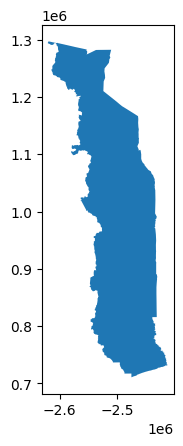

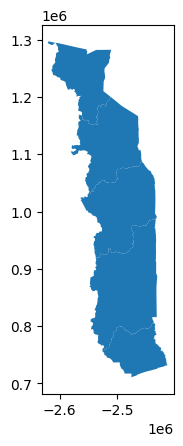

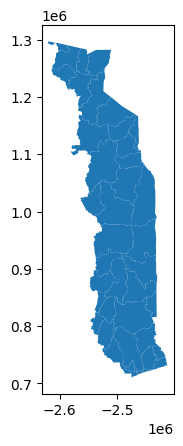

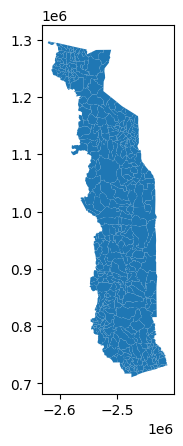

In [10]:
# Generate ADM0, ADM1, and ADM2 by dissolving

gdf_ADM0 = gdf_ADM3.dissolve('ADM0_CODE')
gdf_ADM0.reset_index(inplace = True)
gdf_ADM0.plot()


gdf_ADM1 = gdf_ADM3.dissolve('ADM1_CODE')
gdf_ADM1.reset_index(inplace = True)
gdf_ADM1.plot()


gdf_ADM2 = gdf_ADM3.dissolve('ADM2_CODE')
gdf_ADM2.reset_index(inplace = True)
gdf_ADM2.plot()

gdf_ADM3.plot()

# CRS FINAL CHECK:

print('CRS: ADM0 = {}, ADM1 ={}, ADM2 = {}, ADM3 = {}'.format(gdf_ADM0.crs, gdf_ADM1.crs, gdf_ADM2.crs, gdf_ADM3.crs))

In [11]:
dict_ADM = {'ADM1' : gdf_ADM1, 'ADM2' : gdf_ADM2, 'ADM3' : gdf_ADM3}

In [12]:
for k, v in dict_ADM.items():
  print(k)

ADM1
ADM2
ADM3


##### Agro rasters

In [13]:
SourceFiles = []
SourceFiles = SourceFiles + [i for i in os.listdir(Source_Fd) if i.endswith('tif')]
SourceFiles

['Val_2005_allTech.tif',
 'Val_2005_Irrigated.tif',
 'Val_2010_allTech.tif',
 'Val_2010_Irrigated.tif',
 'HarvArea_2000_allTech.tif',
 'HarvArea_2000_Irrigated.tif',
 'HarvArea_2005_allTech.tif',
 'HarvArea_2005_Irrigated.tif',
 'HarvArea_2010_allTech.tif',
 'HarvArea_2010_Irrigated.tif',
 'HarvArea_2017_allTech.tif',
 'HarvArea_2017_Irrigated.tif',
 'PhysArea_2000_allTech.tif',
 'PhysArea_2000_Irrigated.tif',
 'PhysArea_2005_allTech.tif',
 'PhysArea_2005_Irrigated.tif',
 'PhysArea_2010_allTech.tif',
 'PhysArea_2010_Irrigated.tif',
 'PhysArea_2017_allTech.tif',
 'PhysArea_2017_Irrigated.tif',
 'Val_2017_allTech.tif',
 'Val_2017_Irrigated.tif']

# **MASK RASTERS TO AREA OF INTEREST**

In [14]:
print('CRS : {}'.format(gdf_ADM0.crs))

CRS : ESRI:102022


Extent CRS : ESRI:102022
Vector export complete.


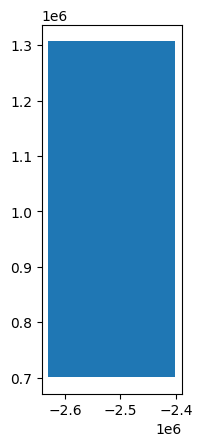

In [15]:
# Generate a box clipping extent from the ADM0 shape
# Using the ADM0 shape as it is may cause the loss of many raster cells
# in the 'rasterClip' process when the shape (i.e., country) is too small
# and/or has a complex boundary (e.g., a lot of rivers, lakes, islands...).
# So, instead, a box shape that covers the entire country will be applied to
# raster clipping to ensure there should be a minimum number of
# 'NoData' cells in the clipping result.

extent_buf = 10000

arry_ADM0_extent = gdf_ADM0.total_bounds
minX, minY, maxX, maxY = arry_ADM0_extent

poly_geom = Polygon([(minX, minY), (minX, maxY), (maxX, maxY), (maxX, minY)]).buffer(extent_buf, join_style=2)

dict_input = {'ADM' : ['ADM0_extent'], 'geometry' : [poly_geom]}

gdf_ADM0_extent = gpd.GeoDataFrame(dict_input).set_crs(gdf_ADM0.crs)

gdf_ADM0_extent.plot()
print('Extent CRS : {}'.format(gdf_ADM0_extent.crs))

tools.vec_export(config.RW_engine, gdf_ADM0_extent, os.path.join(src_interim, 'ADM0_clipExtent.shp'))

In [16]:
totalRas = len(SourceFiles)


### PREPARE DESTINATION FILES
i = 1

for FileName in SourceFiles:

    print('Clipping raster: {} / {} | {}\n'.format(i, totalRas, FileName))

    InputRasterPath = os.path.join(Source_Fd, FileName)
    FinalOutputName = 'Msk_' + FileName
    FinalOutputPath = os.path.join(src_interim, FinalOutputName)


    ### ROAD RASTER AND REPROJECTION

    RX_raster_temp = rioxarray.open_rasterio(InputRasterPath)

    print('ORIGINAL RASTER INFO')

    original_max = np.nanmax(RX_raster_temp.values)
    original_min = np.nanmin(RX_raster_temp.values)

    print('- Range : [{}] - [{}]'.format(original_min, original_max))


    # NODATA MANAGEMENT
    original_nan = RX_raster_temp.rio.nodata
    print('- NoData value : {}'.format(original_nan))

    RX_raster_temp.rio.write_nodata(np.nan, inplace=True)

    np.place(RX_raster_temp[0, :, :].values, RX_raster_temp[0, :, :].values == original_nan, np.nan)

    print('- NoData value transformed from {} to {}'.format(original_nan, RX_raster_temp.rio.nodata))


    ### CLIP
    RX_clipped = RX_raster_temp.rio.clip(gdf_ADM0_extent.geometry.values,
                                         gdf_ADM0_extent.crs,
                                         all_touched = True,
                                         drop = True,
                                         invert = False)


    # GET CLIPPED RASTER SHAPE
    ras_width = RX_clipped.rio.width
    ras_height = RX_clipped.rio.height
    ras_shape = (ras_height, ras_width)
    print('- Clipped Shape : {}'.format(ras_shape))
    print('- Clipped Resolution : {}'.format(RX_clipped.rio.resolution()))

    # REPROJECT
    crs_before_reproject = RX_clipped.rio.crs
    RX_clipped = RX_clipped.rio.reproject(dst_crs = gdf_ADM0_extent.crs, resampling = Resampling.nearest)
    print('- Raster reprojected from {} to {}'.format(crs_before_reproject, gdf_ADM0_extent.crs))


    # GET REPROJECTED RASTER SHAPE
    c_ras_width = RX_clipped.rio.width
    c_ras_height = RX_clipped.rio.height
    c_ras_shape = (c_ras_height, c_ras_width)

    print('\nCLIPPED & REPROJECTED RASTER INFO')
    #print('- Range : [{}] - [{}]'.format(RX_clipped[0, :, :].values.min(), RX_clipped[0, :, :].values.max()))

    post_max = np.nanmax(RX_clipped.values)
    post_min = np.nanmin(RX_clipped.values)

    print('- Range : [{}] - [{}]'.format(post_min, post_max))
    print('- NoData value : {}'.format(RX_clipped.rio.nodata))
    print('- Reprojected Shape : {}'.format(c_ras_shape))
    print('- Reprojected Resolution : {}'.format(RX_clipped.rio.resolution()))

    ### RASTER EXPORT
    RX_clipped.rio.to_raster(FinalOutputPath, compress = 'LZMA')

    i += 1

    print('\n---------------------------------------------------------------------\n')

print('/// COMPLETE ///')

Clipping raster: 1 / 22 | Val_2005_allTech.tif

ORIGINAL RASTER INFO
- Range : [-3.4028234663852886e+38] - [101509024.0]
- NoData value : -3.4028234663852886e+38
- NoData value transformed from -3.4028234663852886e+38 to nan
- Clipped Shape : (63, 28)
- Clipped Resolution : (0.08333333333333018, -0.08333333333332997)
- Raster reprojected from EPSG:4326 to ESRI:102022

CLIPPED & REPROJECTED RASTER INFO
- Range : [11.5] - [9829320.0]
- NoData value : nan
- Reprojected Shape : (64, 26)
- Reprojected Resolution : (9574.387329382884, -9574.387329382884)

---------------------------------------------------------------------

Clipping raster: 2 / 22 | Val_2005_Irrigated.tif

ORIGINAL RASTER INFO
- Range : [-3.4028234663852886e+38] - [94997952.0]
- NoData value : -3.4028234663852886e+38
- NoData value transformed from -3.4028234663852886e+38 to nan
- Clipped Shape : (63, 28)
- Clipped Resolution : (0.08333333333333018, -0.08333333333332997)
- Raster reprojected from EPSG:4326 to ESRI:102022

C

# **RASTER ZONAL STATISTICS**

In [17]:
# Generate src dir automatically if not exist:
src_shapes_dir = os.path.join(src_interim, 'check_shapes')
if not os.path.exists(src_shapes_dir):
    os.mkdir(src_shapes_dir)

In [18]:
stats = ['count','sum','mean']

for k, ADM in dict_ADM.items():


    ADM2shape = ADM.copy()

    joinID = k + '_CODE'
    keepCols = ['ADM0_CODE', joinID]

    print('/////////////// ----> {}'.format(joinID))

    for Indicator in ['Val', 'PhysArea', 'HarvArea']:
        for Tech in ['Irrigated', 'allTech']:
            for Year in ['00', '05', '10', '17']:

                try: # Value of Production doesn't have a year 2000. Doing this to skip over the error.
                    Field = ''.join([Indicator, Year, Tech])

                    ras_name_temp = 'Msk_' + Indicator + '_20' + Year + '_' + Tech + '.tif'
                    src_input_ras_temp = os.path.join(src_interim, ras_name_temp)

                    CSVOut = os.path.join(src_interim, ''.join([Indicator, Year, Tech, '_', joinID.replace('_CODE', ''), '.csv']))



                    ### MAIN PROCESS

                    df_temp = ADM[keepCols].copy()

                    ### IMPORT TEMP RASTER AND CRS CHECK
                    RX_raster_temp = rioxarray.open_rasterio(src_input_ras_temp)
                    print('Imported raster : {}'.format(ras_name_temp))

                    ADM = ADM.to_crs(RX_raster_temp.rio.crs)

                    if RX_raster_temp.rio.crs != ADM.crs:
                        print('WARNING! CRS unmatch - process terminated.')

                    else:

                        print('CRS CHECK OK >> BOTH ADM AND RAS HAVE {}'.format(RX_raster_temp.rio.crs))

                        ### ZONAL STATS BY 'gdf_zone' AND 'stats'
                        # NODATAのセルを無視できるようにする？？
                        # affine = RX_raster_temp.rio.transform(),

                        GJSON_stats_temp = zonal_stats(ADM,
                                                      RX_raster_temp[0, :, :].values,
                                                      stats = stats,
                                                      affine = RX_raster_temp.rio.transform(),
                                                      all_touched = True,
                                                      geojson_out = True)

                        gdf_stats_temp = gpd.GeoDataFrame.from_features(GJSON_stats_temp)

                        df2merge = gdf_stats_temp[stats + [joinID]]

                        df2csv_temp = df_temp.merge(df2merge, on = joinID, how = 'left')



                        for stat_name in stats:
                            col2replace_temp = stat_name + '_' + Indicator + Year + Tech
                            df2csv_temp = df2csv_temp.rename(columns={stat_name : col2replace_temp})

                        df2csv_temp.sample(5)
                        df2csv_temp.to_csv(CSVOut)

                        # Create check shape
                        gdf2shape_temp = ADM2shape.merge(df2csv_temp, on = joinID, how = 'left')

                        shape_name = 'Msk_' + Indicator + '_20' + Year + '_' + Tech + '.shp'
                        tools.vec_export(config.RW_engine, gdf2shape_temp, os.path.join(src_interim, 'check_shapes', shape_name))

                        print('CSV export complete.')
                        print('---------------------------------------------------------------------')

                except:
                    pass

/////////////// ----> ADM1_CODE
Imported raster : Msk_Val_2005_Irrigated.tif
CRS CHECK OK >> BOTH ADM AND RAS HAVE ESRI:102022
Vector export complete.
CSV export complete.
---------------------------------------------------------------------
Imported raster : Msk_Val_2010_Irrigated.tif
CRS CHECK OK >> BOTH ADM AND RAS HAVE ESRI:102022
Vector export complete.
CSV export complete.
---------------------------------------------------------------------
Imported raster : Msk_Val_2017_Irrigated.tif
CRS CHECK OK >> BOTH ADM AND RAS HAVE ESRI:102022
Vector export complete.
CSV export complete.
---------------------------------------------------------------------
Imported raster : Msk_Val_2005_allTech.tif
CRS CHECK OK >> BOTH ADM AND RAS HAVE ESRI:102022
Vector export complete.
CSV export complete.
---------------------------------------------------------------------
Imported raster : Msk_Val_2010_allTech.tif
CRS CHECK OK >> BOTH ADM AND RAS HAVE ESRI:102022
Vector export complete.
CSV export co

# **COMPUTE % CHANGE ACROSS INDICATORS**

In [19]:
FilesList = []

for Indicator in ['Val', 'PhysArea', 'HarvArea']:
    for Tech in ['Irrigated', 'allTech']:
        for ADM in ['ADM1', 'ADM2', 'ADM3']:
            ADM_field = ADM + '_CODE'

            try: # Value of Production doesn't have a year 2000. Doing this to skip over the error.
                String00 = ''.join([Indicator, '00', Tech])
                Year00 = pd.read_csv(os.path.join(Current_Fd, 'Intermediate', ''.join([String00, '_', ADM, '.csv'])))
                Sum00_field = ''.join(['sum_', String00])
            except:
                pass

            String05 = ''.join([Indicator, '05', Tech])
            Year05 = pd.read_csv(os.path.join(Current_Fd, 'Intermediate', ''.join([String05, '_', ADM, '.csv'])))
            Sum05_field = ''.join(['sum_', String05])

            String10 = ''.join([Indicator, '10', Tech])
            Year10 = pd.read_csv(os.path.join(Current_Fd, 'Intermediate', ''.join([String10, '_', ADM, '.csv'])))
            Sum10_field = ''.join(['sum_', String10])

            String17 = ''.join([Indicator, '17', Tech])
            Year17 = pd.read_csv(os.path.join(Current_Fd, 'Intermediate', ''.join([String17, '_', ADM, '.csv'])))
            Sum17_field = ''.join(['sum_', String17])

            try:
                AllYears = Year00.merge(Year05, on=ADM_field).merge(Year10, on=ADM_field).merge(Year17, on=ADM_field)
            except:
                AllYears = Year05.merge(Year10, on=ADM_field).merge(Year17, on=ADM_field)

            # In case of any unnecessary index duplication:
            AllYears = AllYears.loc[:, ~AllYears.columns.str.endswith('_x')]
            AllYears = AllYears.loc[:, ~AllYears.columns.str.endswith('_y')]

            try:
                AllYears['_'.join([Indicator, Tech, 'pc00_05'])] = (AllYears[Sum05_field] - AllYears[Sum00_field]) / AllYears[Sum00_field]
            except:
                pass

            AllYears['_'.join([Indicator, Tech, 'pc05_10'])] = (AllYears[Sum10_field] - AllYears[Sum05_field]) / AllYears[Sum05_field]
            AllYears['_'.join([Indicator, Tech, 'pc10_17'])] = (AllYears[Sum17_field] - AllYears[Sum10_field]) / AllYears[Sum10_field]

            try:
                AllYears['_'.join([Indicator, Tech, 'pc00_17'])] = (AllYears[Sum17_field] - AllYears[Sum00_field]) / AllYears[Sum00_field]
            except:
                pass

            OutName = ''.join([Indicator, Tech, '_', ADM, '.csv'])
            AllYears.to_csv(os.path.join(src_interim, OutName))

            FilesList = FilesList + [OutName]

print(FilesList)

['ValIrrigated_ADM1.csv', 'ValIrrigated_ADM2.csv', 'ValIrrigated_ADM3.csv', 'ValallTech_ADM1.csv', 'ValallTech_ADM2.csv', 'ValallTech_ADM3.csv', 'PhysAreaIrrigated_ADM1.csv', 'PhysAreaIrrigated_ADM2.csv', 'PhysAreaIrrigated_ADM3.csv', 'PhysAreaallTech_ADM1.csv', 'PhysAreaallTech_ADM2.csv', 'PhysAreaallTech_ADM3.csv', 'HarvAreaIrrigated_ADM1.csv', 'HarvAreaIrrigated_ADM2.csv', 'HarvAreaIrrigated_ADM3.csv', 'HarvAreaallTech_ADM1.csv', 'HarvAreaallTech_ADM2.csv', 'HarvAreaallTech_ADM3.csv']


# **FINAL MEEGE AND CSV EXPORT**

In [20]:
ADM3_df = gdf_ADM3[['ADM3_CODE', 'ADM2_CODE', 'ADM1_CODE']].copy()
ADM2_df = gdf_ADM2[['ADM2_CODE', 'ADM1_CODE']].copy()
ADM1_df = gdf_ADM1[['ADM1_CODE']].copy()

print(ADM3_df.info(), ADM2_df.info(), ADM1_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ADM3_CODE  373 non-null    object
 1   ADM2_CODE  373 non-null    object
 2   ADM1_CODE  373 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ADM2_CODE  40 non-null     object
 1   ADM1_CODE  40 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ADM1_CODE  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes
None None None


In [21]:
for File in FilesList:
    df = pd.read_csv(os.path.join(src_interim, File))

    if 'ADM3_CODE' in df.columns:
        JoinID = 'ADM3_CODE'
        ADM3_df = ADM3_df.merge(df, on=JoinID, how = 'left')
        ADM3_df = ADM3_df.loc[:, ~ADM3_df.columns.str.endswith('_x')]
        ADM3_df = ADM3_df.loc[:, ~ADM3_df.columns.str.endswith('_y')]

    elif 'ADM2_CODE' in df.columns:
        JoinID = 'ADM2_CODE'
        ADM2_df = ADM2_df.merge(df, on=JoinID, how = 'left')
        ADM2_df = ADM2_df.loc[:, ~ADM2_df.columns.str.endswith('_x')]
        ADM2_df = ADM2_df.loc[:, ~ADM2_df.columns.str.endswith('_y')]

    else:
        JoinID = 'ADM1_CODE'
        ADM1_df = ADM1_df.merge(df, on=JoinID,  how = 'left')
        ADM1_df = ADM1_df.loc[:, ~ADM1_df.columns.str.endswith('_x')]
        ADM1_df = ADM1_df.loc[:, ~ADM1_df.columns.str.endswith('_y')]

print(ADM3_df.sample(3), ADM2_df.sample(3), ADM1_df.sample(3))

print(len(ADM3_df), len(ADM2_df), len(ADM1_df))


         ADM3_CODE  ADM2_CODE ADM1_CODE  count_Val05Irrigated  \
52   TGO0000040052  TGO000004    TGO000                     4   
277  TGO0030290277  TGO003029    TGO003                     6   
319  TGO0040350319  TGO004035    TGO004                     6   

     sum_Val05Irrigated  mean_Val05Irrigated  count_Val10Irrigated  \
52                  0.0                  0.0                     6   
277                 0.0                  0.0                    10   
319                 0.0                  0.0                     6   

     sum_Val10Irrigated  mean_Val10Irrigated  count_Val17Irrigated  ...  \
52                  0.0                  0.0                     6  ...   
277                 0.0                  0.0                    10  ...   
319                 0.0                  0.0                     6  ...   

     count_HarvArea10allTech  sum_HarvArea10allTech  mean_HarvArea10allTech  \
52                         6           18326.900391             3054.483398   

In [22]:
ADM3_df.to_csv(os.path.join(src_output, 'MapSPAM_summaries_ADM3.csv'))
ADM2_df.to_csv(os.path.join(src_output, 'MapSPAM_summaries_ADM2.csv'))
ADM1_df.to_csv(os.path.join(src_output, 'MapSPAM_summaries_ADM1.csv'))